# Create the Bayesian Network

In [1]:
import pandas as pd
import pickle
from pgmpy.models import BayesianNetwork
import networkx as nx
from utils import hierarchical_layout,draw_graph
import matplotlib.pyplot as plt

# Import the pre-processed dataset and its values mapping
data = pd.read_csv("./datasets/dataset_final.csv")
with open('./datasets/label_mappings.pkl', 'rb') as f: label_mappings = pickle.load(f)

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Models

1. [Model-1: Baseline network](#model-1-baseline-network)
2. [Model-2: Network with a latent variable ](#model-2-network-with-a-latent-variable)

### Model-1: Baseline network

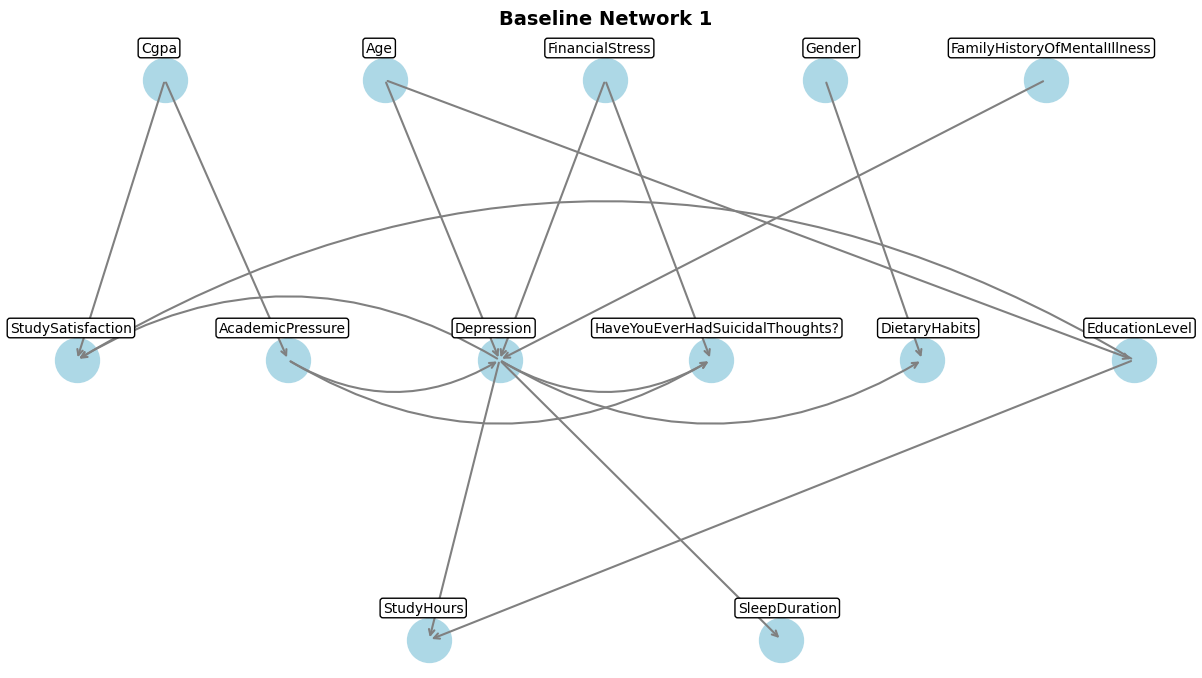

In [ ]:
# Define the network structure
network_baseline = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Depression"),
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Depression"),
    ("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    #("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

network_baseline1 = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    #("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Depression"),
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Depression"),
    ("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    ("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_baseline = BayesianNetwork(network_baseline)
BN_baseline1 = BayesianNetwork(network_baseline1)

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN_baseline.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Baseline Network")

G = nx.DiGraph()
G.add_edges_from(BN_baseline1.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Baseline Network 1")

### Model 2: Network with a latent variable

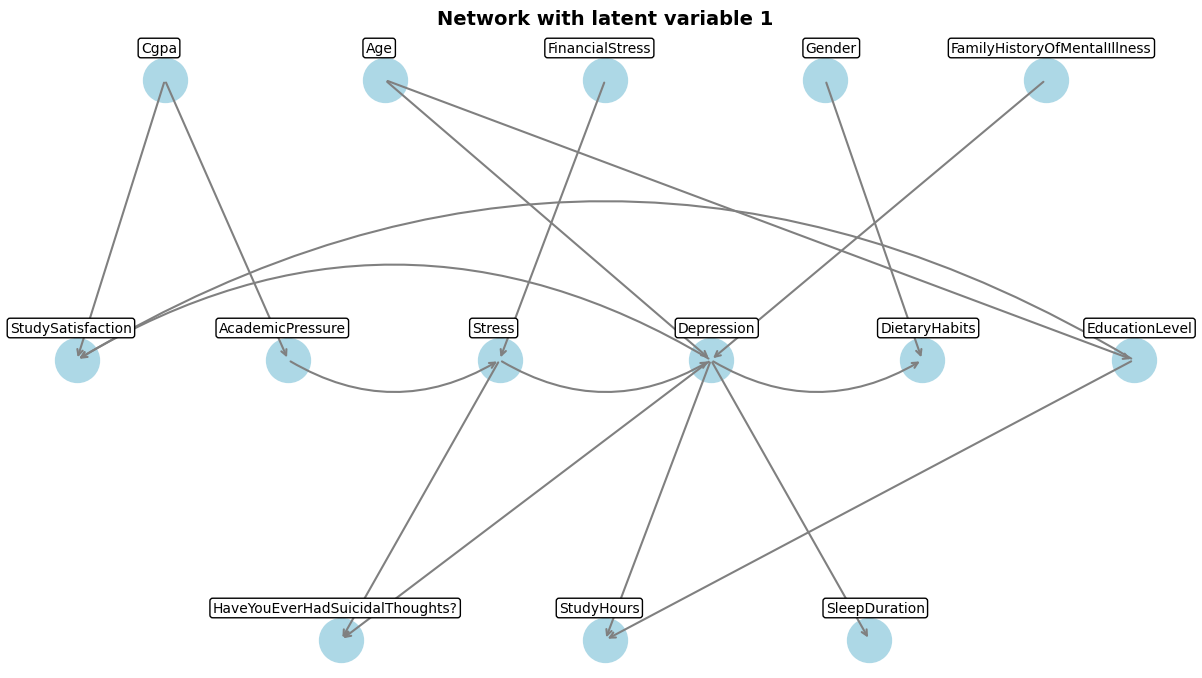

In [ ]:
from pgmpy.factors.discrete import TabularCPD

# Define the network structure
network_latent = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Stress"),                              # added Stress
    ("Stress","Depression"),                                    # added Stress
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Stress"),                               # added Stress
    ("Stress","Depression"),                                    # added Stress
    #("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    #("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    #("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

network_latent1 = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    #("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Stress"),                              # added Stress
    ("Stress","Depression"),                                    # added Stress
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Stress"),                               # added Stress
    ("Stress","Depression"),                                    # added Stress
    #("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    #("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    ("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_latent = BayesianNetwork(network_latent, latents=["Stress"])
BN_latent1 = BayesianNetwork(network_latent1, latents=["Stress"])

# Plot its graph
R = nx.DiGraph()
R.add_edges_from(BN_latent.edges())
pos = hierarchical_layout(R, horizontal_spacing=3.0)
draw_graph(R, pos, title="Network with latent variable")

R = nx.DiGraph()
R.add_edges_from(BN_latent1.edges())
pos = hierarchical_layout(R, horizontal_spacing=3.0)
draw_graph(R, pos, title="Network with latent variable 1")

## Fit Models

In [5]:
models = {
    "Baseline Network" : BN_baseline, 
    "Baseline Network 1": BN_baseline1, 
    "Network with latent variable" : BN_latent, 
    "Network with latent variable 1" : BN_latent1,
}
# Exlude attributes that we reconsidered as unuseful
data_new = data.drop(columns=["EducationCategory", "Regions"])  
random_seed = 42

### PS: BayesianEstimator vs ExpectationMaximization on fully observed BN

In [6]:
import numpy as np
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ExpectationMaximization

import copy

BN_copy_BE = copy.deepcopy(BN_baseline) # Work on a separate copy
be = BayesianEstimator(BN_copy_BE, data_new)
BE_estimation = be.get_parameters()

BN_copy_EM = copy.deepcopy(BN_baseline) # Work on a separate copy
em = ExpectationMaximization(BN_copy_EM, data_new)
EM_estimation = em.get_parameters(seed=random_seed, show_progress=False)

set1 = {cpd.variable: cpd for cpd in BE_estimation}
set2 = {cpd.variable: cpd for cpd in EM_estimation}

avg_diff = {}

for var in set1.keys():
    values1 = np.array(set1[var].values)
    values2 = np.array(set2[var].values)
    avg_diff[var] = np.mean(np.abs(values1 - values2)/np.abs(values1))*100 # Normalized wrt BE (exact ?)

print(f"Average error over all attributes: {np.mean(list(avg_diff.values())):.2f}%")
df_avg_diff = pd.DataFrame({"Attribute":avg_diff.keys(), "Error (%)":avg_diff.values()})
display(df_avg_diff)

Average error over all attributes: 5.02%


,Attribute,Error (%)
0,Depression,5.691164
1,HaveYouEverHadSuicidalThoughts?,4.350958
2,StudySatisfaction,24.726447
3,AcademicPressure,18.686210
4,Cgpa,1.412463
5,Age,0.620364
6,EducationLevel,5.433148
7,FinancialStress,0.001663
8,DietaryHabits,3.034683
9,StudyHours,0.209236


### Fitting

In [7]:
# Setting parameters more easily
fitting_params = {
    "Baseline Network" : {
        "estimator" : BayesianEstimator,
        "params" : {}
    },
    "Baseline Network 1" : {
        "estimator" : BayesianEstimator,
        "params" : {}
    },
    "Network with latent variable" : {
        "estimator" : ExpectationMaximization,
        "params" : {
            "seed": random_seed, 
            "show_progress": False,
            "latent_card":{"Stress": 5},
        }
    }, 
    "Network with latent variable 1" : {
        "estimator" : ExpectationMaximization,
        "params" : {
            "seed": random_seed, 
            "show_progress": False,
            "latent_card":{"Stress": 5},
        }
    }, 
}

In [8]:
import os

param_file = "trained_models.pkl"

# Check if model parameters are already computed
if os.path.exists(param_file):
    with open(param_file, "rb") as f:
        trained_params = pickle.load(f)
else:
    trained_params = {}

# Fit each model at its best
for name, mod in models.items():
    print(f'Model "{name}"')
    if name in trained_params:
        mod.cpds = trained_params[name]
        print(f'\tLoaded pre-trained parameters')
    else:
        # Generali estimation
        estimator = fitting_params[name]["estimator"](mod, data_new)
        estimated_params = estimator.get_parameters(**fitting_params[name]["params"])
        
        mod.cpds = estimated_params
        trained_params[name] = estimated_params
        print(f'\tTrained and saved')

    if not mod.check_model():
        print(f'\tCheck failed')

# Save updated trained parameters
with open(param_file, "wb") as f:
    pickle.dump(trained_params, f)

Model "Baseline Network"
	Loaded pre-trained parameters
Model "Baseline Network 1"
	Loaded pre-trained parameters
Model "Network with latent variable"
	Loaded pre-trained parameters
Model "Network with latent variable 1"
	Loaded pre-trained parameters


### PS: Approximation of `pgmpy.metrics,log_likelihood_score` for networks with latents

In [9]:
# Log functions comparison
from utils import log_like_score
from pgmpy.metrics import log_likelihood_score

res_pgmpy = log_likelihood_score(BN_baseline, data_new)
res_ours = log_like_score(BN_baseline, data_new, show_progress=True)
res_pgmpy1 = log_likelihood_score(BN_baseline1, data_new)
res_ours1 = log_like_score(BN_baseline1, data_new, show_progress=True)

Computing Log-Likelihood: 100%|██████████| 27841/27841 [00:46<00:00, 593.62it/s]


In [11]:
rel_err = np.abs(res_ours-res_pgmpy) / np.abs(res_pgmpy) 
rel_err1 = np.abs(res_ours1-res_pgmpy1) / np.abs(res_pgmpy1) 

print(f"Log-score (pgmpy): {res_pgmpy}")
print(f"Log-score (ours): {res_ours}")
print(f"Relative error: {rel_err*100:.2f}% (wrt to pgmpy)\n")
print(f"Log-score (pgmpy): {res_pgmpy1}")
print(f"Log-score (ours): {res_ours1}")
print(f"Relative error: {rel_err1*100:.2f}% (wrt to pgmpy)")

Log-score (pgmpy): -406589.39511437307
Log-score (ours): -392051.22198980005
Relative error: 3.58% (wrt to pgmpy)

Log-score (pgmpy): -406561.5979838255
Log-score (ours): -392002.2146044336
Relative error: 3.58% (wrt to pgmpy)


In [12]:
# Bic score comparison
from utils import compute_bic
from pgmpy.estimators import BicScore

res_pgmpy_bic = BicScore(data_new).score(BN_baseline)
res_ours_bic = compute_bic(BN_baseline, data_new, log_like_precomputed=res_ours)
res_pgmpy_bic1 = BicScore(data_new).score(BN_baseline1)
res_ours_bic1 = compute_bic(BN_baseline1, data_new, log_like_precomputed=res_ours1)

In [13]:
rel_err_bic = np.abs(res_ours_bic-res_pgmpy_bic) / np.abs(res_pgmpy_bic) 
rel_err_bic1 = np.abs(res_ours_bic1-res_pgmpy_bic1) / np.abs(res_pgmpy_bic1) 

print(f"BIC-score (pgmpy): {res_pgmpy_bic}")
print(f"BIC-score (ours): {res_ours_bic}")
print(f"Relative error: {rel_err_bic*100:.2f}% (wrt to pgmpy)\n")
print(f"BIC-score (pgmpy): {res_pgmpy_bic1}")
print(f"BIC-score (ours): {res_ours_bic1}")
print(f"Relative error: {rel_err_bic1*100:.2f}% (wrt to pgmpy)")

BIC-score (pgmpy): -409715.87255623494
BIC-score (ours): -397618.6621679389
Relative error: 2.95% (wrt to pgmpy)

BIC-score (pgmpy): -409653.8870397104
BIC-score (ours): -397569.65478257247
Relative error: 2.95% (wrt to pgmpy)


## Evaluate Models

In [88]:
from utils import count_bn_parameters, mean_d_separation, compute_sparsity_score, compute_accuracy
from pgmpy.metrics import structure_score
evaluation_df = pd.DataFrame({
    "Scores" : [
        "Number of params",
        "Average D-sep nodes",
        "Sparsity score",
        "Log-likelihood",
        "BIC score",
        "Prediction accuracy"
    ]
})

for name, mod in models.items():    
    n_params = count_bn_parameters(mod)
    d_sep_score = mean_d_separation(mod)
    sparsity_score = compute_sparsity_score(mod)
    log_like = log_like_score(mod, data_new, show_progress=False)
    bic = compute_bic(mod, data_new,log_like_precomputed=log_like) 
    accuracy = compute_accuracy(
        mod, 
        data_new, 
        target_col="Depression",
        train_size=0.8,
        seed=random_seed,
        fitting_params=fitting_params[name],
        show_progress=False
    )
    evaluation_df[name] = [
        n_params,
        d_sep_score,
        sparsity_score,
        log_like,
        bic,
        accuracy
    ]

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/opt/anaconda3/envs/venv/lib/python3.13/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/opt/anaconda3/envs/venv/lib/python3.13/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
/opt/anaconda3/envs/venv/lib/python3.13/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


In [90]:
evaluation_df

,Scores,Baseline Network,Baseline Network 1,Network with latent variable,Network with latent variable 1
0,Number of params,710.000000,710.000000,580.000000,580.000000
1,Average D-sep nodes,0.307692,0.307692,0.340659,0.362637
2,Sparsity score,0.782051,0.782051,0.813187,0.813187
3,Log-likelihood,-392051.221990,-392002.214604,-392352.020085,-392300.599968
4,BIC score,-397618.662168,-397569.654783,-396123.346750,-396071.926633
5,Prediction accuracy,0.840007,0.843598,0.838032,0.843419


### Observations

- **Number of free parameters**

    $$\text{Total Parameters} = \sum_{X \in \text{nodes(BN)}} (r_X - 1) \times Q_X$$

    Where:
    - $r_X$ is the number of states of node $X$,
    - $Q_X$ is the product of the cardinalities of its parents.

    We can notice a great decrease in the number of parameters passing from Baseline models to Latent models (memory usage considerations?).

- **Average number of D-separated nodes**

    $$\text{Mean D-Separation} = \frac{\text{Number of d-separated node pairs}}{\text{Total number of node pairs}}$$

    There is a slight increase in the average number of D-separated nodes, but the scores are still much closer to 0 than to 1, meaning that most node pairs are d-connected, meaning that information can propagate easily through the network.

- **Sparsity score**

    $$\text{Sparsity Score} = 1 - \frac{\text{Number of edges in the network}}{\text{Maximum possible edges}}$$

    Where:
    - $\text{Maximum possible edges} = \frac{n(n-1)}{2}$
    - $n$ is the number of nodes in the Bayesian Network.

    Sparsity increase with latency meanining that we are introducing a simpler structure with fewer dependencies.

- **Log-likelihood / BIC**

    $$(1) \ \ \text{Log-Likelihood} = \sum_{i=1}^{n} \sum_{j=1}^{m} \log P(\text{obs}_{ij} | \text{evidence}_{ij})$$
    Where:
    - $n$ is the number of observations in the dataset.
    - $m$ is the number of variables in the model.
    - $\text{obs}_{ij}$ represents the observed value for the $j$-th variable in the $i$-th row.
    - $\text{evidence}_{ij}$ is the evidence for the $j$-th variable in the $i$-th row, excluding the $j$-th variable.

    $$(2) \ \ \text{BIC} = \text{Log-Likelihood} - \frac{k}{2} \log(n)$$
    Where:
    - $k$ is the number of parameters in the model, calculated as the sum of the cardinalities of the Conditional Probability Distributions (CPDs) minus 1.
    - $n$ is the number of data points in the dataset.

    The first measures how well the model fits the observed data in general and the second one penalizes it with respect to the model complexity. It's interesting to notice how the first score is slightly higher in the Baseline models while the second one is slightly higher in the Latent models.

- **Prediction accuracy on "Depression"**
In all the models the accuracy on predicting "Depression" is quite high (84%) considering a training and testing with a 80-20 split. This is constant even with the introduction of latent nodes, suggesting that it does not compromise predictive power while improving model efficiency. The similar accuracy values further support the idea that latent models maintain strong performance while reducing complexity.

So after those considerations, we can see that both "Baseline Network 1" and its respective latent version are quite better than the other ones so we will use them for the queries.

# Queries

1. [Probability of being depressed given the gender then do it together given other control variables.](#1-probability-of-being-depressed-given-the-gender-then-do-it-together-given-other-control-variables)

2. [Probability of being depressed given the Education Level](#2-probability-of-being-depressed-given-the-education-level)

3. [Probability of depression given high level of Stress (both models)](#3-probability-of-depression-given-high-level-of-stress-both-models)

4. [Probability of symptoms of depression given the fact that the student is depressed](#4-probability-of-symptoms-of-depression-given-the-fact-that-the-student-is-depressed)

5. [Probability of student satisfaction given depression](#5--probability-of-student-satisfaction-given-depression)


In [77]:
from utils import query

# Shut down unuseful warnings
import logging
logging.getLogger('pgmpy').setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


query_models = {
    "Baseline Network 1": BN_baseline1, 
    "Network with latent variable 1" : BN_latent1
}

In [78]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from utils import query
from functools import reduce

def get_nested_value(A, indices):
    '''
    Retrieve the result of a multidimensional array where each index is about a dimension of the array.
    '''
    try:
        for idx in indices:
            A = A[idx]
        return A
    except IndexError:
        print(f"Error: Index {indices} is out of bounds for array with shape {A.shape}")
        return None

def general_query(
    model,
    query_vars, 
    attribute_evidence, 
    index_retrieve_values, 
    show_progress=False
):
    """
    Generalized querying function to handle multiple query variables and index retrieval.
    """

    # Generate all possible combinations of evidence
    evidences = list(ParameterGrid({attr: model.get_cpds(attr).state_names[attr] for attr in attribute_evidence}))

    # Create a DataFrame to store results
    results_df = pd.DataFrame()

    # Collect results for each evidence
    evidence_iter = tqdm(evidences, desc=f"\tProcessing evidences", disable=not show_progress)

    for evidence in evidence_iter:
        result = query(model, query_vars, evidence=evidence)

        # Prepare a dictionary to store the results for each query variable and index
        result_dict = {'Evidence': str(evidence)}
            
        exact_score = get_nested_value(result["exact"]["result"].values, index_retrieve_values)
        exact_time = result["exact"]["time"]
        approx_score = get_nested_value(result["approx"]["result"].values, index_retrieve_values)
        approx_time = result["approx"]["time"]

        # Store results with a clear key format
        result_str = ", ".join(f"{var}={idx}" for var, idx in zip(query_vars, index_retrieve_values))
        result_dict[f'Exact_Score_{result_str}'] = exact_score
        result_dict[f'Exact_Time_{result_str}'] = exact_time
        result_dict[f'Approx_Score_{result_str}'] = approx_score
        result_dict[f'Approx_Time_{result_str}'] = approx_time

        # Convert the result dictionary to a DataFrame and append to results_df
        result_df = pd.DataFrame([result_dict])
        results_df = pd.concat([results_df, result_df], ignore_index=True)

    return results_df


## 1. Probability of being depressed given the control variable (Gender, Age, maybe Family History of Mental Illness).

In [89]:
result_df_1 = {}
for name, model in query_models.items():
    print(f"For model {name}")
    result_df_1[name] = general_query(
        model,
        query_vars=["Depression"],
        attribute_evidence=["Gender", "Age"],
        index_retrieve_values=[1], # only P(Depression=1)
        show_progress=True
    )
    display(result_df_1[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


,Evidence,Exact_Score_Depression=1,Exact_Time_Depression=1,Approx_Score_Depression=1,Approx_Time_Depression=1
0,"{'Age': np.int64(0), 'Gender': np.int64(0)}",0.667379,0.000287,0.681,0.034856
1,"{'Age': np.int64(0), 'Gender': np.int64(1)}",0.667379,0.000266,0.683,0.029254
2,"{'Age': np.int64(1), 'Gender': np.int64(0)}",0.588426,0.000224,0.428,0.039801
3,"{'Age': np.int64(1), 'Gender': np.int64(1)}",0.588426,0.000235,0.380,0.037426
4,"{'Age': np.int64(2), 'Gender': np.int64(0)}",0.455753,0.000238,0.455,0.053919
5,"{'Age': np.int64(2), 'Gender': np.int64(1)}",0.455753,0.000236,0.474,0.041634
6,"{'Age': np.int64(3), 'Gender': np.int64(0)}",0.383961,0.000246,0.605,5.049234
7,"{'Age': np.int64(3), 'Gender': np.int64(1)}",0.383961,0.000268,0.603,3.658549


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


,Evidence,Exact_Score_Depression=1,Exact_Time_Depression=1,Approx_Score_Depression=1,Approx_Time_Depression=1
0,"{'Age': np.int64(0), 'Gender': np.int64(0)}",0.667416,0.000290,0.299,0.033011
1,"{'Age': np.int64(0), 'Gender': np.int64(1)}",0.667416,0.000271,0.333,0.026546
2,"{'Age': np.int64(1), 'Gender': np.int64(0)}",0.587788,0.000244,0.588,0.041463
3,"{'Age': np.int64(1), 'Gender': np.int64(1)}",0.587788,0.000260,0.591,0.033317
4,"{'Age': np.int64(2), 'Gender': np.int64(0)}",0.456952,0.000263,0.535,0.049072
5,"{'Age': np.int64(2), 'Gender': np.int64(1)}",0.456952,0.000245,0.555,0.041731
6,"{'Age': np.int64(3), 'Gender': np.int64(0)}",0.238739,0.000251,0.242,5.004123
7,"{'Age': np.int64(3), 'Gender': np.int64(1)}",0.238739,0.000276,0.756,3.843168


## 2. Probability of being depressed given the Education Level.

In [80]:
result_df_2 = {}
for name, model in query_models.items():
    print(f"For model {name}")
    result_df_2[name] = general_query(
        model,
        query_vars=["Depression"],
        attribute_evidence=["EducationLevel"],
        index_retrieve_values=[1], # only P(Depression=1)
        show_progress=True
    )
    display(result_df_2[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


,Evidence,Exact_Score_Depression=1,Exact_Time_Depression=1,Approx_Score_Depression=1,Approx_Time_Depression=1
0,{'EducationLevel': np.int64(0)},0.655682,0.000878,0.678,0.035759
1,{'EducationLevel': np.int64(1)},0.579129,0.000549,0.571,0.020680
2,{'EducationLevel': np.int64(2)},0.559568,0.000284,0.445,0.027271
3,{'EducationLevel': np.int64(3)},0.542003,0.000266,0.441,0.080706
4,{'EducationLevel': np.int64(4)},0.576097,0.000296,0.410,3.024820


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


,Evidence,Exact_Score_Depression=1,Exact_Time_Depression=1,Approx_Score_Depression=1,Approx_Time_Depression=1
0,{'EducationLevel': np.int64(0)},0.655476,0.000327,0.670,0.052934
1,{'EducationLevel': np.int64(1)},0.579087,0.000312,0.412,0.017325
2,{'EducationLevel': np.int64(2)},0.559536,0.000274,0.410,0.026175
3,{'EducationLevel': np.int64(3)},0.541329,0.000265,0.462,0.083493
4,{'EducationLevel': np.int64(4)},0.577707,0.000303,0.418,3.181412


## 3. Probability of depression given high level of Stress (both models).

In the model baseline model, it is obtained by setting in the evidence all the variables which contribute to stress in the model with the latent variable.

In [81]:
# Here we have to differentiate the queries
result_df_3 = {}

name = "Baseline Network 1"
model = BN_baseline1
print(f"For model {name}")
result_df_3[name] = general_query(
    model,
    query_vars=["Depression"],
    attribute_evidence=["FinancialStress", "AcademicPressure"],
    index_retrieve_values=[1], # only P(Depression=1)
    show_progress=True
)
display(result_df_3[name])


name = "Network with latent variable 1"
model = BN_latent1
print(f"For model {name}")
result_df_3[name] = general_query(
    model,
    query_vars=["Depression"],
    attribute_evidence=["Stress"],
    index_retrieve_values=[1], # only P(Depression=1)
    show_progress=True
)
display(result_df_3[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 30/30 [03:53<00:00,  7.78s/it]


,Evidence,Exact_Score_Depression=1,Exact_Time_Depression=1,Approx_Score_Depression=1,Approx_Time_Depression=1
0,"{'AcademicPressure': np.int64(0), 'FinancialSt...",0.434808,0.000390,0.445,48.262498
1,"{'AcademicPressure': np.int64(0), 'FinancialSt...",0.500000,0.000246,0.520,51.985425
2,"{'AcademicPressure': np.int64(0), 'FinancialSt...",0.464583,0.000245,0.466,46.511477
3,"{'AcademicPressure': np.int64(0), 'FinancialSt...",0.610312,0.000251,0.382,44.320231
4,"{'AcademicPressure': np.int64(0), 'FinancialSt...",0.500428,0.000246,0.527,38.491476
5,"{'AcademicPressure': np.int64(1), 'FinancialSt...",0.076065,0.000262,0.075,0.234710
6,"{'AcademicPressure': np.int64(1), 'FinancialSt...",0.108401,0.000252,0.095,0.214375
7,"{'AcademicPressure': np.int64(1), 'FinancialSt...",0.209553,0.000272,0.209,0.189455
8,"{'AcademicPressure': np.int64(1), 'FinancialSt...",0.285845,0.000249,0.720,0.210385
9,"{'AcademicPressure': np.int64(1), 'FinancialSt...",0.419243,0.000241,0.416,0.136171


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 5/5 [00:00<00:00, 29.63it/s]


,Evidence,Exact_Score_Depression=1,Exact_Time_Depression=1,Approx_Score_Depression=1,Approx_Time_Depression=1
0,{'Stress': 0},0.105698,0.000235,0.104,0.036472
1,{'Stress': 1},0.475292,0.000212,0.472,0.034209
2,{'Stress': 2},0.052499,0.000194,0.056,0.040827
3,{'Stress': 3},0.960688,0.000246,0.038,0.021054
4,{'Stress': 4},0.870098,0.000203,0.141,0.030928


## 4. Probability of the presence of symptoms of depression given the fact that the student is depressed.

In [82]:
result_df_4 = {}
for name, model in query_models.items():
    print(f"For model {name}")
    result_df_4[name] = general_query(
        model,
        query_vars=["DietaryHabits"],
        attribute_evidence=["Depression"],
        index_retrieve_values=[0], # we look for absence and then compute the complement
        show_progress=True
    )
    display(result_df_4[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 47.50it/s]


,Evidence,Exact_Score_DietaryHabits=0,Exact_Time_DietaryHabits=0,Approx_Score_DietaryHabits=0,Approx_Time_DietaryHabits=0
0,{'Depression': np.int64(0)},0.261123,0.000245,0.260,0.022570
1,{'Depression': np.int64(1)},0.446760,0.000167,0.352,0.017313


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 57.05it/s]


,Evidence,Exact_Score_DietaryHabits=0,Exact_Time_DietaryHabits=0,Approx_Score_DietaryHabits=0,Approx_Time_DietaryHabits=0
0,{'Depression': np.int64(0)},0.261125,0.000156,0.385,0.018620
1,{'Depression': np.int64(1)},0.446791,0.000153,0.213,0.014624


In [83]:
result_df_4 = {}
for name, model in query_models.items():
    total_exact=0
    time_exact=0
    total_approx=0
    time_approx=0
    for i in [0, 3]:
        print(f"For model {name}")
        result_df_4[name] = general_query(
            model,
            query_vars=["SleepDuration"],
            attribute_evidence=["Depression"],
            index_retrieve_values=[i], # we look for absence and then compute the complement
            show_progress=True
        )
        total_exact+=result_df_4[name][f'Exact_Score_SleepDuration={i}']
        time_exact+=result_df_4[name][f'Exact_Time_SleepDuration={i}']
        total_approx+=result_df_4[name][f'Approx_Score_SleepDuration={i}']
        time_approx+=result_df_4[name][f'Approx_Time_SleepDuration={i}']
        display(result_df_4[name])
    df_total=pd.DataFrame(data={'Evidence':result_df_4[name]['Evidence'], 'Sum exact':total_exact,
                                 'Time exact': time_exact, 'Sum approximation':total_approx,
                                   'Time approximation':time_approx})
    print(f'Total sum for different sleep duration than average for model {name}')
    display(df_total)


For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 44.88it/s]


,Evidence,Exact_Score_SleepDuration=0,Exact_Time_SleepDuration=0,Approx_Score_SleepDuration=0,Approx_Time_SleepDuration=0
0,{'Depression': np.int64(0)},0.255075,0.000180,0.254,0.024259
1,{'Depression': np.int64(1)},0.328301,0.000166,0.319,0.018336


For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 43.84it/s]


,Evidence,Exact_Score_SleepDuration=3,Exact_Time_SleepDuration=3,Approx_Score_SleepDuration=3,Approx_Time_SleepDuration=3
0,{'Depression': np.int64(0)},0.256633,0.000165,0.243,0.024585
1,{'Depression': np.int64(1)},0.188315,0.000170,0.219,0.019143


Total sum for different sleep duration than average for model Baseline Network 1


,Evidence,Sum exact,Time exact,Sum approximation,Time approximation
0,{'Depression': np.int64(0)},0.511708,0.000345,0.497,0.048844
1,{'Depression': np.int64(1)},0.516616,0.000336,0.538,0.037479


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 51.93it/s]


,Evidence,Exact_Score_SleepDuration=0,Exact_Time_SleepDuration=0,Approx_Score_SleepDuration=0,Approx_Time_SleepDuration=0
0,{'Depression': np.int64(0)},0.255087,0.000193,0.214,0.021881
1,{'Depression': np.int64(1)},0.328321,0.000153,0.191,0.014711


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 49.06it/s]


,Evidence,Exact_Score_SleepDuration=3,Exact_Time_SleepDuration=3,Approx_Score_SleepDuration=3,Approx_Time_SleepDuration=3
0,{'Depression': np.int64(0)},0.256646,0.000151,0.254,0.022018
1,{'Depression': np.int64(1)},0.188313,0.000171,0.273,0.016790


Total sum for different sleep duration than average for model Network with latent variable 1


,Evidence,Sum exact,Time exact,Sum approximation,Time approximation
0,{'Depression': np.int64(0)},0.511733,0.000344,0.468,0.043899
1,{'Depression': np.int64(1)},0.516634,0.000324,0.464,0.031501


In [84]:
result_df_4 = {}
for name, model in query_models.items():
    print(f"For model {name}")
    result_df_4[name] = general_query(
        model,
        query_vars=["StudyHours"],
        attribute_evidence=["Depression"],
        index_retrieve_values=[0], # we look for absence and then compute the complement
        show_progress=True
    )
    display(result_df_4[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 28.18it/s]


,Evidence,Exact_Score_StudyHours=0,Exact_Time_StudyHours=0,Approx_Score_StudyHours=0,Approx_Time_StudyHours=0
0,{'Depression': np.int64(0)},0.231385,0.000665,0.240,0.041811
1,{'Depression': np.int64(1)},0.107494,0.000358,0.512,0.025026


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 52.59it/s]


,Evidence,Exact_Score_StudyHours=0,Exact_Time_StudyHours=0,Approx_Score_StudyHours=0,Approx_Time_StudyHours=0
0,{'Depression': np.int64(0)},0.231378,0.000438,0.355,0.019427
1,{'Depression': np.int64(1)},0.107471,0.000339,0.244,0.016200


In [85]:
result_df_4 = {}
for name, model in query_models.items():
    print(f"For model {name}")
    result_df_4[name] = general_query(
        model,
        query_vars=["HaveYouEverHadSuicidalThoughts?"],
        attribute_evidence=["Depression"],
        index_retrieve_values=[1], # we look for absence and then compute the complement
        show_progress=True
    )
    display(result_df_4[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 45.12it/s]


,Evidence,Exact_Score_HaveYouEverHadSuicidalThoughts?=1,Exact_Time_HaveYouEverHadSuicidalThoughts?=1,Approx_Score_HaveYouEverHadSuicidalThoughts?=1,Approx_Time_HaveYouEverHadSuicidalThoughts?=1
0,{'Depression': np.int64(0)},0.320946,0.000337,0.307,0.023591
1,{'Depression': np.int64(1)},0.853963,0.000308,0.156,0.018209


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 56.81it/s]


,Evidence,Exact_Score_HaveYouEverHadSuicidalThoughts?=1,Exact_Time_HaveYouEverHadSuicidalThoughts?=1,Approx_Score_HaveYouEverHadSuicidalThoughts?=1,Approx_Time_HaveYouEverHadSuicidalThoughts?=1
0,{'Depression': np.int64(0)},0.320712,0.000326,0.338,0.018176
1,{'Depression': np.int64(1)},0.854588,0.000288,0.138,0.014918


In [86]:
result_df_4 = {}
for name, model in query_models.items():
    print(f"For model {name}")
    result_df_4[name] = general_query(
        model,
        query_vars=["DietaryHabits", "SleepDuration", "StudyHours","HaveYouEverHadSuicidalThoughts?"],
        attribute_evidence=["Depression"],
        index_retrieve_values=[0, 0, 0, 0], # we look for absence and then compute the complement
        show_progress=True
    )
    
    # Compute complement
    score_columns = [col for col in result_df_4[name].columns if col.startswith('Exact_Score') or col.startswith('Approx_Score')]
    result_df_4[name][score_columns] = result_df_4[name][score_columns].applymap(lambda x: 1 - x)
    
    display(result_df_4[name])

For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 45.34it/s]


,Evidence,"Exact_Score_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0","Exact_Time_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0","Approx_Score_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0","Approx_Time_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0"
0,{'Depression': np.int64(0)},0.989535,0.000620,0.990,0.023144
1,{'Depression': np.int64(1)},0.997698,0.000433,0.979,0.018141


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 52.39it/s]


,Evidence,"Exact_Score_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0","Exact_Time_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0","Approx_Score_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0","Approx_Time_DietaryHabits=0, SleepDuration=0, StudyHours=0, HaveYouEverHadSuicidalThoughts?=0"
0,{'Depression': np.int64(0)},0.989531,0.000427,0.991,0.019953
1,{'Depression': np.int64(1)},0.997708,0.000424,0.968,0.015750


## 5.  Probability of high student satisfaction given depression.

In [87]:
result_df_5 = {}
for name, model in query_models.items():
    total_exact=0
    time_exact=0
    total_approx=0
    time_approx=0
    for i in  range(3,5):
        print(f"For model {name}")
        result_df_5[name] = general_query(
            model,
            query_vars=["StudySatisfaction"],
            attribute_evidence=["Depression"],
            index_retrieve_values=[i], # we look for absence and then compute the complement
            show_progress=True
        )
        total_exact+=result_df_5[name][f'Exact_Score_StudySatisfaction={i}']
        time_exact+=result_df_5[name][f'Exact_Time_StudySatisfaction={i}']
        total_approx+=result_df_5[name][f'Approx_Score_StudySatisfaction={i}']
        time_approx+=result_df_5[name][f'Approx_Time_StudySatisfaction={i}']
        display(result_df_5[name])
    print(f'Total sum for high student satisfaction given being depressed or not for model {name}')
    df_total=pd.DataFrame(data={'Evidence':result_df_5[name]['Evidence'], 'Sum exact':total_exact,
                                 'Time exact': time_exact, 'Sum approximation':total_approx,
                                   'Time approximation':time_approx})
    display(df_total)

For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 46.19it/s]


,Evidence,Exact_Score_StudySatisfaction=3,Exact_Time_StudySatisfaction=3,Approx_Score_StudySatisfaction=3,Approx_Time_StudySatisfaction=3
0,{'Depression': np.int64(0)},0.212661,0.000380,0.197,0.023265
1,{'Depression': np.int64(1)},0.205707,0.000332,0.186,0.017700


For model Baseline Network 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 48.03it/s]


,Evidence,Exact_Score_StudySatisfaction=4,Exact_Time_StudySatisfaction=4,Approx_Score_StudySatisfaction=4,Approx_Time_StudySatisfaction=4
0,{'Depression': np.int64(0)},0.268814,0.000328,0.119,0.022488
1,{'Depression': np.int64(1)},0.198605,0.000321,0.139,0.017045


Total sum for high student satisfaction given being depressed or not for model Baseline Network 1


,Evidence,Sum exact,Time exact,Sum approximation,Time approximation
0,{'Depression': np.int64(0)},0.481475,0.000708,0.316,0.045753
1,{'Depression': np.int64(1)},0.404313,0.000653,0.325,0.034745


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 54.99it/s]


,Evidence,Exact_Score_StudySatisfaction=3,Exact_Time_StudySatisfaction=3,Approx_Score_StudySatisfaction=3,Approx_Time_StudySatisfaction=3
0,{'Depression': np.int64(0)},0.212675,0.000338,0.128,0.019422
1,{'Depression': np.int64(1)},0.205710,0.000327,0.215,0.014799


For model Network with latent variable 1


	Processing evidences: 100%|██████████| 2/2 [00:00<00:00, 55.36it/s]


,Evidence,Exact_Score_StudySatisfaction=4,Exact_Time_StudySatisfaction=4,Approx_Score_StudySatisfaction=4,Approx_Time_StudySatisfaction=4
0,{'Depression': np.int64(0)},0.268832,0.000349,0.187,0.019022
1,{'Depression': np.int64(1)},0.198608,0.000334,0.227,0.014907


Total sum for high student satisfaction given being depressed or not for model Network with latent variable 1


,Evidence,Sum exact,Time exact,Sum approximation,Time approximation
0,{'Depression': np.int64(0)},0.481507,0.000687,0.315,0.038444
1,{'Depression': np.int64(1)},0.404318,0.000662,0.442,0.029706
